NOTES:

I think I might have to recollect the data, or at least review all 100 posts again to determine if some of the posts are just neutral emotions instead of just either positve or negative?

I'm just gonna use the polarity_scores method as it looks so much easier?
1. input data
2. preprocess data
3. apply the sentiment analyzer

### Import Packages

In [73]:
import nltk
nltk.download('all')
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
%matplotlib inline

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to
[nltk_data]    |     /Users/howieli/nltk_data...
[nltk_data]    |   Package abc is already up-to-date!
[nltk_data]    | Downloading package alpino to
[nltk_data]    |     /Users/howieli/nltk_data...
[nltk_data]    |   Package alpino is already up-to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /Users/howieli/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger is already up-
[nltk_data]    |       to-date!
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /Users/howieli/nltk_data...
[nltk_data]    |   Package averaged_perceptron_tagger_ru is already
[nltk_data]    |       up-to-date!
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /Users/howieli/nltk_data...
[nltk_data]    |   Package basque_grammars is already up-to-date!
[nltk_data]    | Downloading pa

### Import Data Sets

In [74]:
r_lonely_data = pd.read_csv('r_lonely.csv')
r_casualConversation_data = pd.read_csv('r_casualConversation.csv')

### Interpret the data set
by making graphs to visualize the distribution

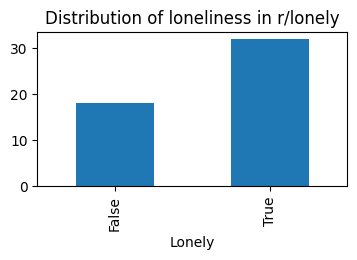

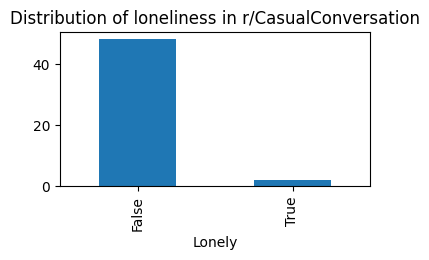

In [75]:
rlonelyplt = r_lonely_data['Loneliness'].value_counts().sort_index().plot(kind = 'bar', title = 'Distribution of loneliness in r/lonely', figsize = (4, 2))
rlonelyplt.set_xlabel('Lonely')
plt.show()
rcasualplt = r_casualConversation_data['Loneliness'].value_counts().sort_index().plot(kind = 'bar', title = 'Distribution of loneliness in r/CasualConversation', figsize = (4, 2))
rcasualplt.set_xlabel('Lonely')
plt.show()

We can interpret from the data that majority of data posts is determined to be lonely in the r_lonely subreddit, and the situation is completely opposite in r/CasualConversation subreddit, which almost none of the posts are considered to be lonely.

### Separate Groups for prediction
I'll separate the data into train and test data. Since the r_lonely_data and r_casualConversation_data have such a big difference in terms of results, I don't really think we can treat it as the same data set but rather treat it as one dataset with two different situations. So I'll be splitting the two sets both by half to contribution as train and test data.

In [76]:
combined_data = pd.concat([r_lonely_data, r_casualConversation_data], ignore_index = True)
train_data, test_data = train_test_split(combined_data, test_size = 0.5, random_state = 42)
train_data.head(10)

,Title,Post,Loneliness
24,I am feeling worried about the coming months. ...,I just feel so scared and worried and I have b...,False
3,Alone in my room,It is 2:40 in the morning. I am alone in my ro...,True
17,My youth is over,My family destroyed and ruined my childhood an...,True
38,"With Aspergers and related issues, am I (21M) ...","I don’t know how, I don’t have the confidence ...",True
8,I’m lonely and suicidal,I have no friends and my family doesn’t care a...,True
78,Nineteen Eighty-Four is such an incredible boo...,I've been thinking a lot lately about the book...,False
6,25M bored out of my mind,"Hi, I’m 25, 6’2 (I swear that’s not my entire ...",False
64,top 5 fav fruit?,Not sure if this is the right place for this l...,False
36,I mourn for myself,"Sometimes, I mourn for the hopes and dreams I ...",True
89,Running Shoe,I’m looking for a reasonably priced running sh...,False


### Text processing (another method I wanna try)
tokenize, encode, and vectorize the inputs for later use in machine learning algorithm

In [77]:
def preprocess_text(text):
    tokens = word_tokenize(text.lower())
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]

    lemmatizer = WordNetLemmatizer()
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    processed_text = ' '.join(lemmatized_tokens)

    return processed_text

In [78]:
combined_data['Post'] = combined_data['Post'].apply(preprocess_text)
combined_data.head()

,Title,Post,Loneliness
0,Got a raise in my salary and I feel very miser...,"today ( 28m ) got raise job , salary went 110k...",True
1,28M - Looking for long-term chat buddies,ive got varied interest load different thing '...,False
2,Do you share your problems with anyone?,almost 30 y/o life felt good people . problem ...,True
3,Alone in my room,2:40 morning . alone room watching movie cry l...,True
4,Need Advice,already posted r/askmen feel guy understand im...,False


Initialize the Sentiment Intensity Analyzer

In [39]:
sia = SentimentIntensityAnalyzer()

measure_sentiment_intensity that measures the sentiment intensity of a sentence

In [40]:
def get_sentiment_intensity(text_data):
    return sia.polarity_scores(text_data)

average_sentiment, which calculate the average sentiment score by averaging both the title's sentiment score and the post's sentiment score from a data in the dataframe.

In [41]:
def average_sentiment(title, post):
    title_scores = measure_sentiment_intensity(title)
    post_scores = measure_sentiment_intensity(post)
    average_neg = (title_scores['neg'] + post_scores['neg']) / 2
    average_neu = (title_scores['neu'] + post_scores['neu']) / 2
    average_pos = (title_scores['pos'] + post_scores['pos']) / 2

    return average_neg, average_neu, average_pos

Create a new list to store the result and convert to dataframe later.

In [42]:
sentiment_results = []

Iterate through the dataframe r_lonely_data, and get the sentiment score for each row.

In [43]:
for index, row in r_lonely_data.iterrows():
    avg_neg, avg_neu, avg_pos = average_sentiment(row['Title'], row['Post'])
    sentiment_results.append({'Average_Neg' : avg_neg, 'Average_Neu' : avg_neu, 'Average_Pos' : avg_pos})

In [44]:
# Create the dataframe using the results above.
sentiment_df = pd.DataFrame(sentiment_results)

# Playing with the data
print(sentiment_df.shape)
print(sentiment_df.head(10))
print(r_lonely_data.iloc[8])

(50, 3)
   Average_Neg  Average_Neu  Average_Pos
0       0.2385       0.7190       0.0430
1       0.0000       0.9035       0.0965
2       0.2085       0.6025       0.1890
3       0.3115       0.6330       0.0555
4       0.0425       0.8710       0.0865
5       0.0255       0.7820       0.1925
6       0.2260       0.6720       0.1015
7       0.1030       0.8350       0.0620
8       0.4620       0.3950       0.1430
9       0.0435       0.9080       0.0485
Title                                   I’m lonely and suicidal
Post          I have no friends and my family doesn’t care a...
Loneliness                                                 True
Name: 8, dtype: object
